In [2]:
import sys
import penaltyblog as pb
sys.path.append("../../")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance

df = pd.read_csv("https://www.football-data.co.uk/mmz4281/2223/E0.csv")
df = df[["Date", "HomeTeam", "AwayTeam", "FTHG", "FTAG"]]
df.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG
0,05/08/2022,Crystal Palace,Arsenal,0,2
1,06/08/2022,Fulham,Liverpool,2,2
2,06/08/2022,Bournemouth,Aston Villa,2,0
3,06/08/2022,Leeds,Wolves,2,1
4,06/08/2022,Newcastle,Nott'm Forest,2,0


# Custom functions

In [3]:
def simulate_season(sim, model):
    for index, row in sim.iterrows():
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']
        
        probs = model.predict(home_team, away_team)
        home_goal_expectation = probs.home_goal_expectation
        away_goal_expectation = probs.away_goal_expectation
        
        home_goals = np.random.poisson(home_goal_expectation)
        away_goals = np.random.poisson(away_goal_expectation)
        
        sim.at[index, 'HG'] = home_goals
        sim.at[index, 'AG'] = away_goals

    sim['HG'] = sim['HG'].astype(int)
    sim['AG'] = sim['AG'].astype(int)

    return sim

def calculate_standings(sim):
    team_stats = {}

    for index, row in sim.iterrows():
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']
        home_goals = row['HG']
        away_goals = row['AG']
        
        # Update or initialize stats for home team
        if home_team in team_stats:
            team_stats[home_team]['GF'] += home_goals
            team_stats[home_team]['GA'] += away_goals
            team_stats[home_team]['GD'] += (home_goals - away_goals)
            team_stats[home_team]['PTS'] += (3 if home_goals > away_goals else (1 if home_goals == away_goals else 0))
            team_stats[home_team]['P'] += 1
        
            if home_goals > away_goals:
                team_stats[home_team]['W'] += 1
            elif home_goals == away_goals:
                team_stats[home_team]['D'] += 1
            else:
                team_stats[home_team]['L'] += 1
        else:
            team_stats[home_team] = {'GF': home_goals, 'GA': away_goals, 'GD': (home_goals - away_goals),
                                    'PTS': (3 if home_goals > away_goals else (1 if home_goals == away_goals else 0)),
                                    'P': 1, 'W': 1 if home_goals > away_goals else 0,
                                    'D': 1 if home_goals == away_goals else 0, 'L': 1 if home_goals < away_goals else 0}

        # Update or initialize stats for away team
        if away_team in team_stats:
            team_stats[away_team]['GF'] += away_goals
            team_stats[away_team]['GA'] += home_goals
            team_stats[away_team]['GD'] += (away_goals - home_goals)
            team_stats[away_team]['PTS'] += (3 if away_goals > home_goals else (1 if away_goals == home_goals else 0))
            team_stats[away_team]['P'] += 1
            
            if away_goals > home_goals:
                team_stats[away_team]['W'] += 1
            elif away_goals == home_goals:
                team_stats[away_team]['D'] += 1
            else:
                team_stats[away_team]['L'] += 1
        else:
            team_stats[away_team] = {'GF': away_goals, 'GA': home_goals, 'GD': (away_goals - home_goals),
                                    'PTS': (3 if away_goals > home_goals else (1 if away_goals == home_goals else 0)),
                                    'P': 1, 'W': 1 if away_goals > home_goals else 0,
                                    'D': 1 if away_goals == home_goals else 0, 'L': 1 if away_goals < home_goals else 0}

    standings = pd.DataFrame.from_dict(team_stats, orient='index')
    standings.index.name = 'Team'

    # Calculate additional stats like Goal Difference, Wins, Draws, Losses, and Points Percentage
    standings['GD'] = standings['GF'] - standings['GA']
    standings['%'] = round((standings['PTS'] / (standings['P'] * 3)) * 100, 1)

    # Sort the standings by Points, Goal Difference, and Goals For
    standings = standings.sort_values(by=['PTS', 'GD', 'GF'], ascending=False)

    # Add Position (Pos) column
    standings.reset_index(inplace=True)
    standings['Pos'] = standings.index + 1
    standings.set_index('Pos', inplace=True)
    standings.index.name = 'Pos'
    standings = standings[['Team', 'PTS', 'P', 'W', 'D', 'L', 'GF', 'GA', 'GD', '%']]
    standings.reset_index(inplace=True)

    return standings

def euclidean_distance(df1, df2):
    if df1.shape != df2.shape:
        raise ValueError("Dataframes must have the same shape")

    # Calculate squared differences element-wise
    squared_diff = (df1 - df2) ** 2

    # Calculate RMSE (square root of mean of squared differences)
    rmse = np.sqrt(np.mean(squared_diff.values))
    return rmse

# Dixon Coles

In [4]:
dc = pb.models.DixonColesGoalModel(
    df["FTHG"], df["FTAG"], df["HomeTeam"], df["AwayTeam"]
)

dc.fit()

dc

Module: Penaltyblog

Model: Dixon and Coles

Number of parameters: 42
Log Likelihood: -1098.77
AIC: 2281.54

Team                 Attack               Defence             
------------------------------------------------------------
Arsenal              1.529                -1.049              
Aston Villa          0.985                -1.018              
Bournemouth          0.688                -0.595              
Brentford            1.11                 -1.018              
Brighton             1.335                -0.858              
Chelsea              0.688                -1.014              
Crystal Palace       0.741                -0.973              
Everton              0.583                -0.819              
Fulham               1.068                -0.874              
Leeds                0.951                -0.497              
Leicester            1.01                 -0.63               
Liverpool            1.369                -0.977              
Man City   

## Simulating a match

In [5]:
num_simulations = 1000
home_team = "Arsenal"
away_team = "Leicester"

probs = dc.predict(home_team, away_team)
home_goal_expectation = probs.home_goal_expectation
away_goal_expectation = probs.away_goal_expectation

print(home_team, "xG -", home_goal_expectation)
print(away_team, "xG -", away_goal_expectation)

poisson_home_goals = np.random.poisson(home_goal_expectation)
poisson_away_goals = np.random.poisson(away_goal_expectation)

print("\nMATCH SIMULATION")
print(home_team, "-", poisson_home_goals)
print(away_team, "-", poisson_away_goals)

Arsenal xG - 3.2872064539625856
Leicester xG - 0.9615575006542334

MATCH SIMULATION
Arsenal - 1
Leicester - 1


## Simulating a match 1000 times

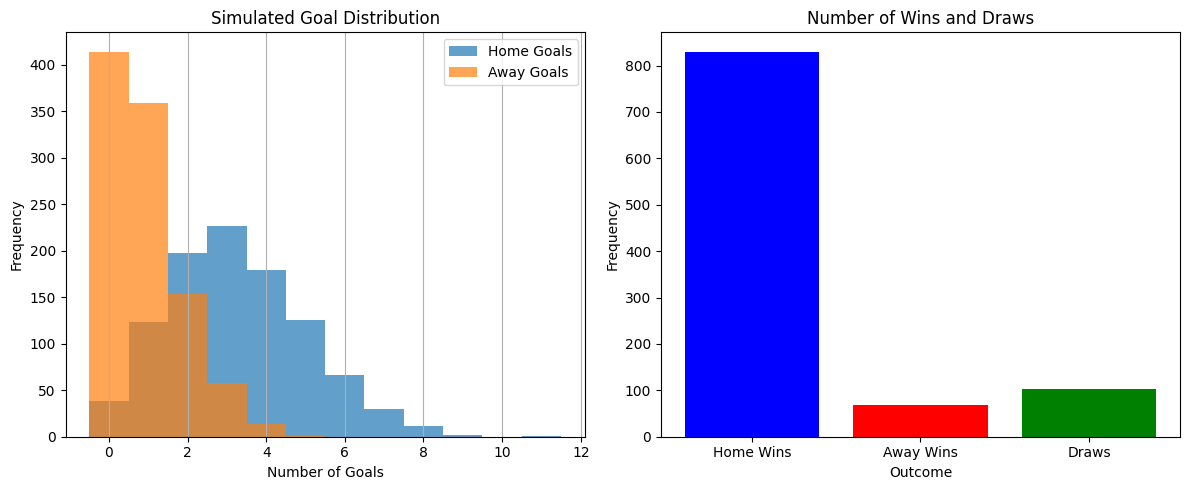

In [6]:
home_goals_simulated = np.random.poisson(home_goal_expectation, num_simulations)
away_goals_simulated = np.random.poisson(away_goal_expectation, num_simulations)

home_wins = np.sum(home_goals_simulated > away_goals_simulated)
away_wins = np.sum(home_goals_simulated < away_goals_simulated)
draws = np.sum(home_goals_simulated == away_goals_simulated)

# Plotting the distributions
plt.figure(figsize=(12, 5))

# Plotting goal distributions
plt.subplot(1, 2, 1)
plt.hist(home_goals_simulated, bins=np.arange(-0.5, max(home_goals_simulated) + 1.5, 1), alpha=0.7, label='Home Goals')
plt.hist(away_goals_simulated, bins=np.arange(-0.5, max(away_goals_simulated) + 1.5, 1), alpha=0.7, label='Away Goals')
plt.xlabel('Number of Goals')
plt.ylabel('Frequency')
plt.title('Simulated Goal Distribution')
plt.legend()
plt.grid(True, axis='x')

# Plotting win counts
plt.subplot(1, 2, 2)
labels = ['Home Wins', 'Away Wins', 'Draws']
values = [home_wins, away_wins, draws]
plt.bar(labels, values, color=['blue', 'red', 'green'])
plt.xlabel('Outcome')
plt.ylabel('Frequency')
plt.title('Number of Wins and Draws')

plt.tight_layout()
plt.show()

## Simulating the championship

In [7]:
sim = df[['HomeTeam', 'AwayTeam']].copy()
sim.head()

,HomeTeam,AwayTeam
0,Crystal Palace,Arsenal
1,Fulham,Liverpool
2,Bournemouth,Aston Villa
3,Leeds,Wolves
4,Newcastle,Nott'm Forest


In [8]:
sim_matches_dc = simulate_season(sim, dc)
sim_standings_dc = calculate_standings(sim_matches_dc)
sim_standings_dc

,Pos,Team,PTS,P,W,D,L,GF,GA,GD,%
0,1,Arsenal,87,38,27,6,5,76,29,47,76.3
1,2,Newcastle,78,38,24,6,8,70,38,32,68.4
2,3,Liverpool,73,38,21,10,7,68,43,25,64.0
3,4,Man City,72,38,22,6,10,85,37,48,63.2
4,5,Fulham,65,38,19,8,11,56,44,12,57.0
5,6,Aston Villa,63,38,18,9,11,54,43,11,55.3
6,7,Man United,60,38,17,9,12,61,36,25,52.6
7,8,Brentford,60,38,18,6,14,55,44,11,52.6
8,9,Crystal Palace,58,38,16,10,12,48,53,-5,50.9
9,10,Brighton,57,38,15,12,11,65,50,15,50.0


## Simulating the championship 1000 times

In [21]:
all_standings_dc = []
num_simulations = 100

for i in range(num_simulations):
    matches = simulate_season(sim, dc)
    standings = calculate_standings(matches)
    all_standings_dc.append(standings)

# Now calculate the average standings
average_standings_dc = pd.concat(all_standings_dc).groupby('Team').mean().reset_index()

# Sort the average standings by Points, Goal Difference, and Goals For
average_standings_dc = average_standings_dc.sort_values(by=['PTS', 'GD', 'GF'], ascending=False)

# Add Position (Pos) column
average_standings_dc['Pos'] = average_standings_dc.index + 1
average_standings_dc.set_index('Pos', inplace=True)
average_standings_dc.index.name = 'Pos'
average_standings_dc = average_standings_dc[['Team', 'PTS', 'P', 'W', 'D', 'L', 'GF', 'GA', 'GD', '%']]
average_standings_dc.reset_index(drop=True, inplace=True)

# Display the average standings
average_standings_dc

,Team,PTS,P,W,D,L,GF,GA,GD,%
0,Man City,85.86,38.0,26.53,6.27,5.20,95.10,33.66,61.44,75.315
1,Arsenal,77.43,38.0,23.44,7.11,7.45,86.95,43.01,43.94,67.919
2,Newcastle,74.19,38.0,21.85,8.64,7.51,66.78,32.59,34.19,65.082
3,Liverpool,68.89,38.0,20.22,8.23,9.55,73.82,46.46,27.36,60.432
4,Brighton,64.02,38.0,18.74,7.80,11.46,71.94,53.50,18.44,56.155
5,Man United,62.46,38.0,17.85,8.91,11.24,58.72,44.02,14.70,54.785
6,Brentford,61.10,38.0,17.34,9.08,11.58,58.27,45.35,12.92,53.596
7,Aston Villa,57.13,38.0,16.00,9.13,12.87,51.86,44.96,6.90,50.115
8,Tottenham,56.88,38.0,16.47,7.47,14.06,70.18,62.81,7.37,49.895
9,Fulham,54.64,38.0,15.21,9.01,13.78,54.40,52.33,2.07,47.929


## Real standings

In [ ]:
real = df.copy()
real.drop(columns=['Date'], inplace=True)
real.rename(columns={'FTHG': 'HG', 'FTAG': 'AG'}, inplace=True)

real_standings = calculate_standings(real)
real_standings

,Pos,Team,PTS,P,W,D,L,GF,GA,GD,%
0,1,Man City,89,38,28,5,5,94,33,61,78.1
1,2,Arsenal,84,38,26,6,6,88,43,45,73.7
2,3,Man United,75,38,23,6,9,58,43,15,65.8
3,4,Newcastle,71,38,19,14,5,68,33,35,62.3
4,5,Liverpool,67,38,19,10,9,75,47,28,58.8
5,6,Brighton,62,38,18,8,12,72,53,19,54.4
6,7,Aston Villa,61,38,18,7,13,51,46,5,53.5
7,8,Tottenham,60,38,18,6,14,70,63,7,52.6
8,9,Brentford,59,38,15,14,9,58,46,12,51.8
9,10,Fulham,52,38,15,7,16,55,53,2,45.6


## Comparing Real and Sim standings

In [ ]:
# Merge real_standings and sim_standings on 'Team' to compare attributes
comparison = pd.merge(real_standings, average_standings, on='Team', suffixes=('_real', '_sim'))

# Calculate absolute differences for each attribute
attributes = ['PTS', 'W', 'D', 'L', 'GF', 'GA', 'GD', '%']
for attr in attributes:
    comparison[f'{attr}_diff'] = abs(comparison[f'{attr}_sim'] - comparison[f'{attr}_real'])

# Reorder columns for better readability (if needed)
comparison = comparison[['Team'] + [f'{attr}_real' for attr in attributes] + [f'{attr}_sim' for attr in attributes] + [f'{attr}_diff' for attr in attributes]]

diff_columns = [col for col in comparison.columns if col.endswith('_diff')]
diff_columns.append('Team')
comparison = comparison[diff_columns]
columns_order = ['Team'] + [col for col in comparison.columns if col != 'Team']
comparison = comparison[columns_order]
comparison.columns = comparison.columns.str.replace('_diff', '')

comparison_dc = comparison
comparison_dc

,Team,PTS,W,D,L,GF,GA,GD,%
0,Man City,2.805,1.380,1.335,0.045,0.675,0.415,1.090,2.4920
1,Arsenal,5.740,2.150,0.710,1.440,0.750,0.500,0.250,5.0515
2,Man United,12.150,5.085,3.105,1.980,0.225,0.445,0.670,10.6725
3,Newcastle,3.660,3.045,5.475,2.430,0.105,0.405,0.300,3.1910
4,Liverpool,2.045,1.435,2.260,0.825,0.785,0.280,1.065,1.7670
5,Brighton,2.805,1.090,0.465,0.625,0.165,0.495,0.330,2.4440
6,Aston Villa,4.840,2.480,2.600,0.120,0.605,0.250,0.855,4.2345
7,Tottenham,2.675,1.440,1.645,0.205,0.315,0.445,0.130,2.3175
8,Brentford,1.235,2.180,5.305,3.125,0.615,0.435,1.050,1.0360
9,Fulham,2.015,0.020,1.955,1.975,0.275,0.050,0.225,1.7840


# Rue Salvesen

In [ ]:
rs = pb.models.RueSalvesenGoalModel(
    df["FTHG"], df["FTAG"], df["HomeTeam"], df["AwayTeam"]
)

rs.fit()

rs

Module: Penaltyblog

Model: Rue Salvesen

Number of parameters: 43
Log Likelihood: -1086.68
AIC: 2259.361

Team                 Attack               Defence             
------------------------------------------------------------
Arsenal              1.591                -1.09               
Aston Villa          0.974                -0.986              
Bournemouth          0.683                -0.631              
Brentford            1.117                -1.004              
Brighton             1.381                -0.897              
Chelsea              0.637                -0.941              
Crystal Palace       0.702                -0.914              
Everton              0.544                -0.758              
Fulham               1.09                 -0.875              
Leeds                1.007                -0.546              
Leicester            1.055                -0.67               
Liverpool            1.305                -0.997              
Man City     

## Simulating a match

In [ ]:
num_simulations = 1000
home_team = "Arsenal"
away_team = "Leicester"

probs = rs.predict(home_team, away_team)
home_goal_expectation = probs.home_goal_expectation
away_goal_expectation = probs.away_goal_expectation

print(home_team, "xG -", home_goal_expectation)
print(away_team, "xG -", away_goal_expectation)

poisson_home_goals = np.random.poisson(home_goal_expectation)
poisson_away_goals = np.random.poisson(away_goal_expectation)

print("\nMATCH SIMULATION")
print(home_team, "-", poisson_home_goals)
print(away_team, "-", poisson_away_goals)

Arsenal xG - 3.255940349037347
Leicester xG - 0.9815642289657865

MATCH SIMULATION
Arsenal - 3
Leicester - 1


## Simulating a match 1000 times

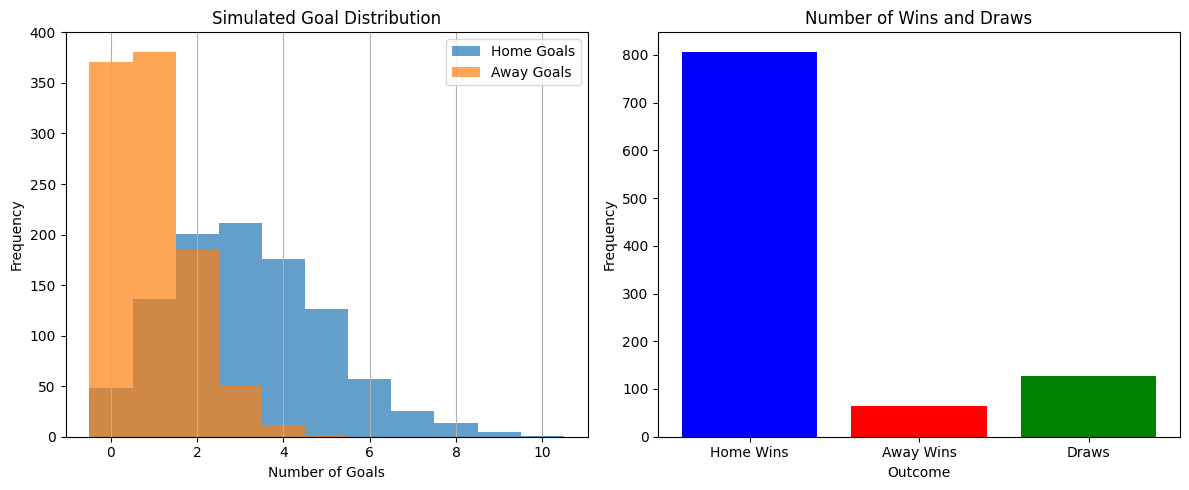

In [ ]:
home_goals_simulated = np.random.poisson(home_goal_expectation, num_simulations)
away_goals_simulated = np.random.poisson(away_goal_expectation, num_simulations)

home_wins = np.sum(home_goals_simulated > away_goals_simulated)
away_wins = np.sum(home_goals_simulated < away_goals_simulated)
draws = np.sum(home_goals_simulated == away_goals_simulated)

# Plotting the distributions
plt.figure(figsize=(12, 5))

# Plotting goal distributions
plt.subplot(1, 2, 1)
plt.hist(home_goals_simulated, bins=np.arange(-0.5, max(home_goals_simulated) + 1.5, 1), alpha=0.7, label='Home Goals')
plt.hist(away_goals_simulated, bins=np.arange(-0.5, max(away_goals_simulated) + 1.5, 1), alpha=0.7, label='Away Goals')
plt.xlabel('Number of Goals')
plt.ylabel('Frequency')
plt.title('Simulated Goal Distribution')
plt.legend()
plt.grid(True, axis='x')

# Plotting win counts
plt.subplot(1, 2, 2)
labels = ['Home Wins', 'Away Wins', 'Draws']
values = [home_wins, away_wins, draws]
plt.bar(labels, values, color=['blue', 'red', 'green'])
plt.xlabel('Outcome')
plt.ylabel('Frequency')
plt.title('Number of Wins and Draws')

plt.tight_layout()
plt.show()

## Simulating the championship

In [ ]:
sim = df[['HomeTeam', 'AwayTeam']].copy()
sim.head()

,HomeTeam,AwayTeam
0,Crystal Palace,Arsenal
1,Fulham,Liverpool
2,Bournemouth,Aston Villa
3,Leeds,Wolves
4,Newcastle,Nott'm Forest


In [ ]:
sim_matches_rs = simulate_season(sim, rs)
sim_standings_rs = calculate_standings(sim_matches_rs)
sim_standings_rs

,Pos,Team,PTS,P,W,D,L,GF,GA,GD,%
0,1,Arsenal,86,38,26,8,4,88,36,52,75.4
1,2,Man City,84,38,26,6,6,111,35,76,73.7
2,3,Newcastle,81,38,24,9,5,71,32,39,71.1
3,4,Man United,78,38,24,6,8,65,35,30,68.4
4,5,Fulham,62,38,19,5,14,72,56,16,54.4
5,6,Crystal Palace,60,38,17,9,12,66,50,16,52.6
6,7,Brentford,58,38,18,4,16,57,45,12,50.9
7,8,Aston Villa,58,38,17,7,14,59,51,8,50.9
8,9,West Ham,56,38,16,8,14,52,44,8,49.1
9,10,Brighton,54,38,16,6,16,54,60,-6,47.4


## Simulating the championship 1000 times

In [ ]:
all_standings = []
num_simulations = 100

for i in range(num_simulations):
    matches = simulate_season(sim, rs)
    standings = calculate_standings(matches)
    all_standings.append(standings)

# Now calculate the average standings
average_standings = pd.concat(all_standings).groupby('Team').mean().reset_index()

# Sort the average standings by Points, Goal Difference, and Goals For
average_standings = average_standings.sort_values(by=['PTS', 'GD', 'GF'], ascending=False)

# Add Position (Pos) column
average_standings['Pos'] = average_standings.index + 1
average_standings.set_index('Pos', inplace=True)
average_standings.index.name = 'Pos'
average_standings = average_standings[['Team', 'PTS', 'P', 'W', 'D', 'L', 'GF', 'GA', 'GD', '%']]
average_standings.reset_index(drop=True, inplace=True)

# Display the average standings
average_standings_rs = average_standings
average_standings_rs

,Team,PTS,P,W,D,L,GF,GA,GD,%
0,Man City,86.485,38.0,26.740,6.265,4.995,92.825,32.345,60.480,75.8615
1,Arsenal,78.740,38.0,23.955,6.875,7.170,89.435,43.040,46.395,69.0700
2,Newcastle,74.360,38.0,21.835,8.855,7.310,66.850,33.245,33.605,65.2260
3,Liverpool,64.935,38.0,18.905,8.220,10.875,66.810,47.480,19.330,56.9610
4,Brighton,64.100,38.0,18.860,7.520,11.620,71.635,53.370,18.265,56.2215
5,Man United,63.435,38.0,18.010,9.405,10.585,56.840,40.745,16.095,55.6450
6,Brentford,60.570,38.0,17.260,8.790,11.950,58.145,46.505,11.640,53.1290
7,Tottenham,57.645,38.0,16.625,7.770,13.605,69.645,62.205,7.440,50.5670
8,Aston Villa,55.935,38.0,15.530,9.345,13.125,50.440,45.465,4.975,49.0675
9,Fulham,54.530,38.0,15.170,9.020,13.810,54.970,52.845,2.125,47.8345


In [ ]:
euclidean_distances = []

# Iterate through each standings DataFrame in all_standings
for i, standings_df in enumerate(all_standings):
    # Calculate the Euclidean distance between the standings and the average_standings DataFrame
    euclidean_dist = distance.euclidean(
        average_standings.select_dtypes(include=np.number).values.ravel(),
        standings_df.select_dtypes(include=np.number).values.ravel()
    )
    
    # Append the index and Euclidean distance to the list
    euclidean_distances.append({'index': i, 'euclidean_distance': euclidean_dist})

# Create a DataFrame from the list of Euclidean distances
euclidean_rs = pd.DataFrame(euclidean_distances)

# Display the euclidean_df
euclidean_rs

## Real standings

In [ ]:
real = df.copy()
real.drop(columns=['Date'], inplace=True)
real.rename(columns={'FTHG': 'HG', 'FTAG': 'AG'}, inplace=True)

real_standings = calculate_standings(real)
real_standings

,Pos,Team,PTS,P,W,D,L,GF,GA,GD,%
0,1,Man City,89,38,28,5,5,94,33,61,78.1
1,2,Arsenal,84,38,26,6,6,88,43,45,73.7
2,3,Man United,75,38,23,6,9,58,43,15,65.8
3,4,Newcastle,71,38,19,14,5,68,33,35,62.3
4,5,Liverpool,67,38,19,10,9,75,47,28,58.8
5,6,Brighton,62,38,18,8,12,72,53,19,54.4
6,7,Aston Villa,61,38,18,7,13,51,46,5,53.5
7,8,Tottenham,60,38,18,6,14,70,63,7,52.6
8,9,Brentford,59,38,15,14,9,58,46,12,51.8
9,10,Fulham,52,38,15,7,16,55,53,2,45.6


## Comparing Real and Sim standings

In [ ]:
# Merge real_standings and sim_standings on 'Team' to compare attributes
comparison = pd.merge(real_standings, average_standings, on='Team', suffixes=('_real', '_sim'))

# Calculate absolute differences for each attribute
attributes = ['PTS', 'W', 'D', 'L', 'GF', 'GA', 'GD', '%']
for attr in attributes:
    comparison[f'{attr}_diff'] = abs(comparison[f'{attr}_sim'] - comparison[f'{attr}_real'])

# Reorder columns for better readability (if needed)
comparison = comparison[['Team'] + [f'{attr}_real' for attr in attributes] + [f'{attr}_sim' for attr in attributes] + [f'{attr}_diff' for attr in attributes]]

diff_columns = [col for col in comparison.columns if col.endswith('_diff')]
diff_columns.append('Team')
comparison = comparison[diff_columns]
columns_order = ['Team'] + [col for col in comparison.columns if col != 'Team']
comparison = comparison[columns_order]
comparison.columns = comparison.columns.str.replace('_diff', '')

comparison_rs = comparison
comparison_rs

,Team,PTS,W,D,L,GF,GA,GD,%
0,Man City,2.515,1.260,1.265,0.005,1.175,0.655,0.520,2.2385
1,Arsenal,5.260,2.045,0.875,1.170,1.435,0.040,1.395,4.6300
2,Man United,11.565,4.990,3.405,1.585,1.160,2.255,1.095,10.1550
3,Newcastle,3.360,2.835,5.145,2.310,1.150,0.245,1.395,2.9260
4,Liverpool,2.065,0.095,1.780,1.875,8.190,0.480,8.670,1.8390
5,Brighton,2.100,0.860,0.480,0.380,0.365,0.370,0.735,1.8215
6,Aston Villa,5.065,2.470,2.345,0.125,0.560,0.535,0.025,4.4325
7,Tottenham,2.355,1.375,1.770,0.395,0.355,0.795,0.440,2.0330
8,Brentford,1.570,2.260,5.210,2.950,0.145,0.505,0.360,1.3290
9,Fulham,2.530,0.170,2.020,2.190,0.030,0.155,0.125,2.2345


# Final comparison

## Real standings

In [ ]:
real_standings

,Pos,Team,PTS,P,W,D,L,GF,GA,GD,%
0,1,Man City,89,38,28,5,5,94,33,61,78.1
1,2,Arsenal,84,38,26,6,6,88,43,45,73.7
2,3,Man United,75,38,23,6,9,58,43,15,65.8
3,4,Newcastle,71,38,19,14,5,68,33,35,62.3
4,5,Liverpool,67,38,19,10,9,75,47,28,58.8
5,6,Brighton,62,38,18,8,12,72,53,19,54.4
6,7,Aston Villa,61,38,18,7,13,51,46,5,53.5
7,8,Tottenham,60,38,18,6,14,70,63,7,52.6
8,9,Brentford,59,38,15,14,9,58,46,12,51.8
9,10,Fulham,52,38,15,7,16,55,53,2,45.6


## Dixon Coles table

In [ ]:
comparison_dc

,Team,PTS,W,D,L,GF,GA,GD,%
0,Man City,2.805,1.380,1.335,0.045,0.675,0.415,1.090,2.4920
1,Arsenal,5.740,2.150,0.710,1.440,0.750,0.500,0.250,5.0515
2,Man United,12.150,5.085,3.105,1.980,0.225,0.445,0.670,10.6725
3,Newcastle,3.660,3.045,5.475,2.430,0.105,0.405,0.300,3.1910
4,Liverpool,2.045,1.435,2.260,0.825,0.785,0.280,1.065,1.7670
5,Brighton,2.805,1.090,0.465,0.625,0.165,0.495,0.330,2.4440
6,Aston Villa,4.840,2.480,2.600,0.120,0.605,0.250,0.855,4.2345
7,Tottenham,2.675,1.440,1.645,0.205,0.315,0.445,0.130,2.3175
8,Brentford,1.235,2.180,5.305,3.125,0.615,0.435,1.050,1.0360
9,Fulham,2.015,0.020,1.955,1.975,0.275,0.050,0.225,1.7840


## Rue Salvesen table

In [ ]:
comparison_rs

,Team,PTS,W,D,L,GF,GA,GD,%
0,Man City,2.515,1.260,1.265,0.005,1.175,0.655,0.520,2.2385
1,Arsenal,5.260,2.045,0.875,1.170,1.435,0.040,1.395,4.6300
2,Man United,11.565,4.990,3.405,1.585,1.160,2.255,1.095,10.1550
3,Newcastle,3.360,2.835,5.145,2.310,1.150,0.245,1.395,2.9260
4,Liverpool,2.065,0.095,1.780,1.875,8.190,0.480,8.670,1.8390
5,Brighton,2.100,0.860,0.480,0.380,0.365,0.370,0.735,1.8215
6,Aston Villa,5.065,2.470,2.345,0.125,0.560,0.535,0.025,4.4325
7,Tottenham,2.355,1.375,1.770,0.395,0.355,0.795,0.440,2.0330
8,Brentford,1.570,2.260,5.210,2.950,0.145,0.505,0.360,1.3290
9,Fulham,2.530,0.170,2.020,2.190,0.030,0.155,0.125,2.2345


## Points predictions

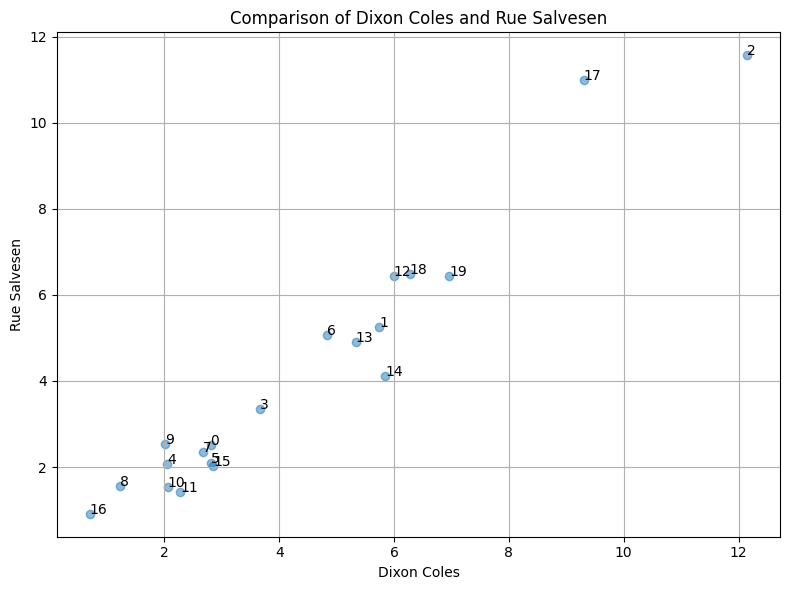

In [ ]:
plt.figure(figsize=(8, 6))

plt.scatter(comparison_dc['PTS'], comparison_rs['PTS'], alpha=0.5)
plt.xlabel('Dixon Coles')
plt.ylabel('Rue Salvesen')
plt.title('Comparison of Dixon Coles and Rue Salvesen')
plt.grid(True)

# Annotate each point with the team name
for i, team in enumerate(comparison_dc.index):
    plt.text(comparison_dc['PTS'][i], comparison_rs['PTS'][i], team)

plt.tight_layout()
plt.show()

## Goals predictions

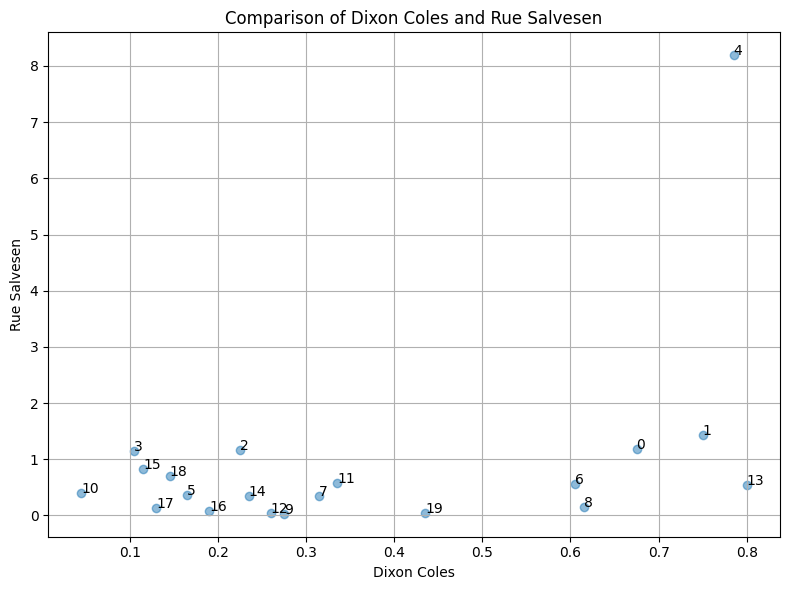

In [ ]:
plt.figure(figsize=(8, 6))

plt.scatter(comparison_dc['GF'], comparison_rs['GF'], alpha=0.5)
plt.xlabel('Dixon Coles')
plt.ylabel('Rue Salvesen')
plt.title('Comparison of Dixon Coles and Rue Salvesen')
plt.grid(True)

# Annotate each point with the team name
for i, team in enumerate(comparison_dc.index):
    plt.text(comparison_dc['GF'][i], comparison_rs['GF'][i], team)

plt.tight_layout()
plt.show()